# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


In [ ]:
!nvidia-smi

Mon Feb  8 22:39:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Приаттачим Google Drive и будем брать оттуда файл `get_dataset.py`

In [ ]:
from google.colab import drive

gdrive_root_folder = "/content/gdrive"

drive.mount(gdrive_root_folder)

!cp /content/gdrive/MyDrive/autoencoders/get_dataset.py .

Mounted at /content/gdrive


# Vanilla Autoencoder (2 балла)

## Prepare the data


In [ ]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import torchvision
from torchvision import transforms
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsTransformer
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
import itertools
import tqdm
import skimage.util
from skimage.draw import rectangle
%matplotlib inline

np.random.seed(42)
torch.manual_seed(42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Напишем общие утилитные функции

In [ ]:
def tensor_to_image(tensor):
    image_numpy = tensor.numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))

    return image_numpy

def draw_images(images, number, title):
    fig = plt.figure(figsize=(2 * number, 2 * number))

    i = 0
    for image in itertools.islice(images, number):
        image = tensor_to_image(image)

        ax = fig.add_subplot(1, number, i + 1)

        if image.shape[2] == 1:
            image = image.squeeze()
            imgplot = plt.imshow(image, cmap="gray")
        else:
            imgplot = plt.imshow(image)

        plt.xticks([])
        plt.yticks([])
        plt.title(title)
        i = i + 1
    plt.show()

def draw_image(image, title):
    image = tensor_to_image(image)

    fig = plt.figure(figsize=(2, 2))

    if image.shape[2] == 1:
        image = image.squeeze()
        plt.imshow(image, cmap="gray")
    else:
        plt.imshow(image)

    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()

def draw_losses(train_losses, val_losses):
    fig = plt.figure(figsize=(10, 5))
    plt.plot(range(len(train_losses)), train_losses, label='train losses')
    plt.plot(range(len(val_losses)), val_losses, label='val losses')
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Train and Validation Losses")
    plt.legend()
    plt.show()

Напишем общую функцию для цикла обучения, которую будем использовать для обучения трех моделей: Vanilla AE, Variational AE, CVAE

In [ ]:
def train(model, criterion, optimizer, scheduler, epoch_number, train_data_loader, val_data_loader):
    train_losses = []
    val_losses = []

    for epoch in tqdm.trange(epoch_number):
        # Training
        avg_train_loss = 0
        model.train()  # train mode
        for image, label in train_data_loader:
            image = image.to(device)

            optimizer.zero_grad()

            image_hat, mu, logsigma = model(image, label)
            loss = criterion(image, mu, logsigma, image_hat)
            loss.backward()
            optimizer.step()

            avg_train_loss += loss.detach().cpu()
        avg_train_loss /= len(train_data_loader)

        # Validation
        avg_val_loss = 0
        model.eval()
        for image, label in val_data_loader:
            image = image.to(device)
            
            image_hat, mu, logsigma = model(image, label)
            with torch.no_grad():
                loss = criterion(image, mu, logsigma, image_hat)

            avg_val_loss += loss.detach().cpu()
        avg_val_loss /= len(val_data_loader)

        print(f"train loss: {avg_train_loss}, validation loss: {avg_val_loss}")
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        scheduler.step(avg_val_loss)

        # Show intermediate results
        original_images, labels = next(iter(val_data_loader))
        original_images = original_images.to(device)
        labels = labels.to(device)
        reconstructed_images = model(original_images, labels)[0]
        reconstructed_images = reconstructed_images.detach().cpu()
        original_images = original_images.detach().cpu()

        draw_images(original_images, 15, "original")
        draw_images(reconstructed_images, 15, "reconstructed")

    return train_losses, val_losses

Еще пара утилитных функций: для изображения реконструированных картинок и для сэмплинга

In [ ]:
def draw_train_and_val_images(train_data_loader, val_data_loader):
    train_images, _ = next(iter(train_data_loader))
    val_images, _ = next(iter(val_data_loader))

    draw_images(train_images, 10, "train")
    draw_images(val_images, 10, "val")

def reconstruct_and_draw(model, val_data_loader):
    original_images, original_labels = next(iter(val_data_loader))
    original_images = original_images.to(device)
    original_labels = original_labels.to(device)

    reconstructed_images, _, _ = model(original_images, original_labels)
    reconstructed_images = reconstructed_images.detach().cpu()

    original_images = original_images.cpu()

    draw_images(original_images, 10, "original")
    draw_images(reconstructed_images, 10, "reconstructed")

def sample_and_draw(model, latent_size):
    z = np.array([np.random.normal(0, 1, latent_size) for i in range(10)])
    z = torch.Tensor(z).to(device)

    model.eval()
    output = model.decode(z).detach().cpu()
    draw_images(output, 10, "generated")

def sample_with_label_and_draw(model, latent_size, class_number):
    z = np.array([np.random.normal(0, 1, latent_size) for i in range(10)])
    z = torch.Tensor(z).to(device)

    for i in range(0, class_number):
        label = np.full(10, i)
        one_hot_label = F.one_hot(torch.as_tensor(label), class_number)
        one_hot_label = one_hot_label.to(device)

        model.eval()
        output = model.decode(z, one_hot_label).detach().cpu()
        draw_images(output, 10, "generated")

def draw_latent_vectors(model, val_data_loader):
    model.eval()
    fig = plt.figure(figsize=(10, 10))
    for image, label in val_data_loader:
        image = image.to(device)

        image_hat, latent_vector, _ = model(image, label)
        latent_vector = latent_vector.detach().cpu().numpy()

        latent_vector_embedded = TSNE().fit_transform(latent_vector)

        plt.scatter(x=latent_vector_embedded[:, 0], y=latent_vector_embedded[:, 1], c=label, alpha=0.5)

    plt.legend()
    plt.show()

Будем использовать 2 датасета: лица и MNIST. Создадим для них data loaders и покажем несколько картинок из датасета

Начнем с датасета лиц

In [ ]:
class ImageAndIndexDataset(data_utils.Dataset):
    def __init__(self, images):
        super().__init__()

        self.images = images
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return (self.to_tensor(self.images[idx]).float(), idx)

In [ ]:
from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

dataset = ImageAndIndexDataset(data)

train_size = int(len(data) * 0.8)
val_size = len(data) - int(len(data) * 0.8)

face_train_data, face_val_data = data_utils.random_split(dataset, [train_size, val_size])

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


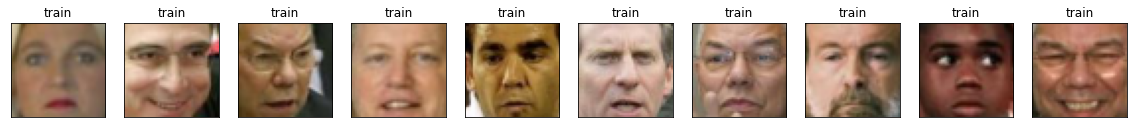

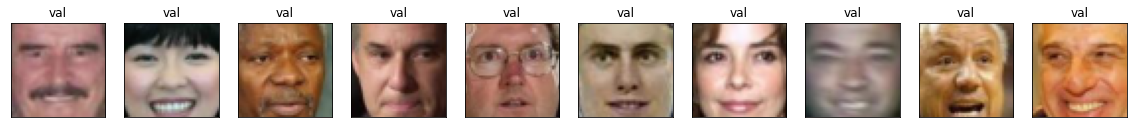

In [ ]:
face_batch_size = 1024

face_train_data_loader = data_utils.DataLoader(
    face_train_data,
    batch_size=face_batch_size,
    shuffle=True)
face_val_data_loader = data_utils.DataLoader(
    face_val_data,
    batch_size=face_batch_size,
    shuffle=False)

face_image_shape = next(iter(face_train_data_loader))[0][0].shape

draw_train_and_val_images(face_train_data_loader, face_val_data_loader)

Теперь сделаем то же самое для MNIST

Extracting /datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /datasets/mnist/MNIST/raw


Extracting /datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /datasets/mnist/MNIST/raw


Extracting /datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /datasets/mnist/MNIST/raw


Extracting /datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /datasets/mnist/MNIST/raw
Processing...



Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


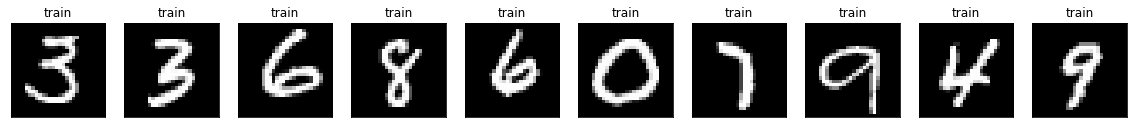

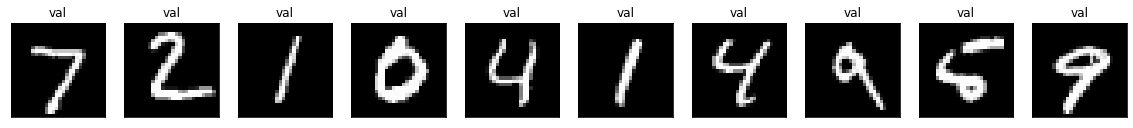

In [ ]:
mnist_batch_size = 4096

transformers = torchvision.transforms.ToTensor()

mnist_train_data_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/datasets/mnist', train=True, download=True, transform=transformers),
  batch_size=mnist_batch_size, shuffle=True)

mnist_val_data_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/datasets/mnist', train=False, download=True, transform=transformers),
  batch_size=mnist_batch_size, shuffle=False)

mnist_image_shape = next(iter(mnist_train_data_loader))[0][0].shape
mnist_class_number = 10

draw_train_and_val_images(mnist_train_data_loader, mnist_val_data_loader)

In [ ]:
face_latent_size = 256
mnist_latent_size = 20

## Autoencoder
В этом разделе мы напишем и обучем обычный автоэнкодер.

Надеюсь, что к этому моменту вы уже почитали про автоэнкодеры и знаете, зачем они нужны и какова их архитектура. Если нет, то начните с этих ссылок: 

https://habr.com/ru/post/331382/ \\
https://towardsdatascience.com\intuitively-understanding-variational-autoencoders-1bfe67eb5daf



<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

^ вот так выглядит автоэнкодер

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_shape, latent_size):
        super().__init__()

        input_channels = input_shape[0]
        input_size = input_shape[1]

        target_size = input_size // 4

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(128 * target_size * target_size, latent_size),
            nn.BatchNorm1d(latent_size),
            nn.ReLU(True))
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 128 * target_size * target_size),
            nn.BatchNorm1d(128 * target_size * target_size),
            nn.ReLU(True),
            nn.Unflatten(1, (128, target_size, target_size)),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=32, out_channels=input_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(input_channels),
            nn.Sigmoid())

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)
        
    def forward(self, x, label):
        latent = self.encode(x)
        reconstruction = self.decode(latent)

        latent_code = latent.clone().detach()

        return reconstruction, latent_code, latent_code

In [ ]:
bce_loss = nn.BCELoss()

def loss_ae(x, mu, logsigma, reconstruction):
    return bce_loss(reconstruction, x)

ae = Autoencoder(face_image_shape, face_latent_size).to(device)

optimizer = optim.Adam(ae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
epoch_number = 200

train_losses, val_losses = train(ae, loss_ae, optimizer, scheduler, epoch_number, face_train_data_loader, face_val_data_loader)

In [ ]:
torch.save(ae.state_dict(), '/content/gdrive/MyDrive/autoencoders/models/face_ae.pth')

Графики train и val loss:

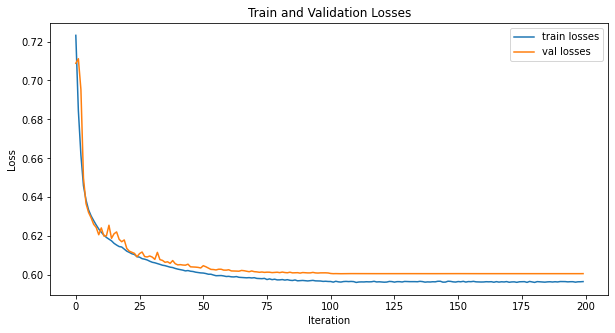

In [ ]:
draw_losses(train_losses, val_losses)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

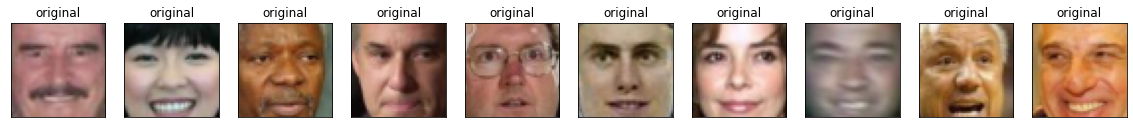

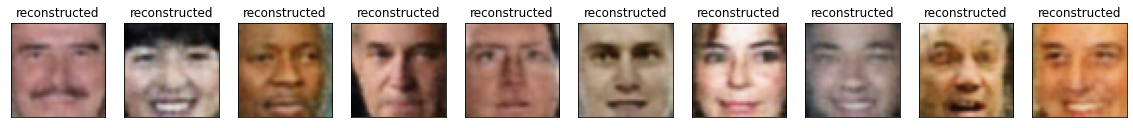

In [ ]:
reconstruct_and_draw(ae, face_val_data_loader)

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

Попробуем сэмплировать латентные вектора из N(0, 1) и реконструировать по ним картинки

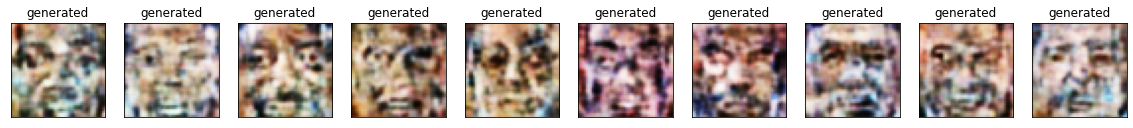

In [ ]:
sample_and_draw(ae, face_latent_size)

Попробуем генерить латентные вектора не из N(0, 1), а по следующему алгоритму.

Посчитаем средний латентный вектор и будем генерить новые латентные вектора как средний плюс нормальный шум



In [ ]:
def mean_latent_vector(model, val_data, latent_size, predicate):
    mean_latent_vector = torch.zeros(latent_size)

    model.eval()

    to_tensor = transforms.ToTensor()

    i = 0
    for image, index in val_data:
        image = image.unsqueeze(0)
        image = image.to(device)

        _, latent_vector, _ = model(image, index)
        latent_vector = latent_vector.detach().cpu()

        attr = attrs.iloc[[index]]

        if predicate(attr):
            mean_latent_vector += latent_vector.squeeze(0)
            i += 1

    mean_latent_vector /= i

    return mean_latent_vector

mlv = mean_latent_vector(ae, face_val_data, face_latent_size, lambda attr: True)

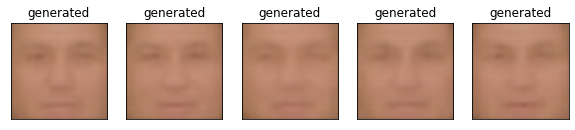

In [ ]:
def generate_latent_vector(real_latent_vector):
    return real_latent_vector + torch.normal(0, 0.05, real_latent_vector.shape)

z = []
for i in range(25):
    z.append(generate_latent_vector(mlv))

z = torch.stack(z, dim=0)
z = z.to(device)

ae.eval()
output = ae.decoder(z).detach().cpu()

draw_images(output, 5, "generated")

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

Посчитаем вектор улыбок - smile_vector

In [ ]:
smile_latent_vector = mean_latent_vector(ae, face_val_data, face_latent_size, lambda attr: attr['Smiling'].item() > 0.5)
non_smile_latent_vector = mean_latent_vector(ae, face_val_data, face_latent_size, lambda attr: attr['Smiling'].item() < -0.5)

smile_vector = smile_latent_vector - non_smile_latent_vector

Возьмем случайного неулыбвающегося человека и сделаем ему улыбку

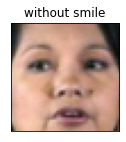

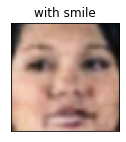

In [ ]:
person_without_smile_index = attrs[attrs['Smiling'] < -0.5].sample().index.item()

to_tensor = transforms.ToTensor()

person_without_smile_image = data[person_without_smile_index]
person_without_smile_image = to_tensor(person_without_smile_image).float()
person_without_smile_image = person_without_smile_image.unsqueeze(0)
person_without_smile_image = person_without_smile_image.to(device)

ae.eval()
_, person_without_smile_vector, _ = ae(person_without_smile_image, person_without_smile_index)
person_without_smile_vector = person_without_smile_vector.detach().cpu()

person_with_smile_vector = person_without_smile_vector + smile_vector
person_with_smile_vector = person_with_smile_vector.to(device)
person_with_smile_image = ae.decoder(person_with_smile_vector)

person_without_smile_image = person_without_smile_image.detach().cpu()
person_with_smile_image = person_with_smile_image.detach().cpu()

person_without_smile_image = person_without_smile_image.squeeze(0)
person_with_smile_image = person_with_smile_image.squeeze(0)

draw_image(person_without_smile_image, "without smile")
draw_image(person_with_smile_image, "with smile")

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (3 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_shape, latent_size):
        super().__init__()

        input_channels = input_shape[0]
        input_size = input_shape[1]
        target_size = input_size // 4
       
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Flatten())
        
        self.mu = nn.Linear(64 * target_size * target_size, latent_size)
        self.logsigma = nn.Linear(64 * target_size * target_size, latent_size)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 64 * target_size * target_size),
            nn.BatchNorm1d(64 * target_size * target_size),
            nn.ReLU(True),
            nn.Unflatten(1, (64, target_size, target_size)),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=input_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(input_channels),
            nn.Sigmoid())

    def encode(self, x):
        encoded = self.encoder(x)
       
        mu = self.mu(encoded)
        logsigma = self.logsigma(encoded)

        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            sigma = logsigma.exp()

            eps = torch.FloatTensor(sigma.size()).normal_().to(device)
            return eps.mul(sigma).add(mu)
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        return self.decoder(z)
        
    def forward(self, x, label):
        mu, logsigma = self.encode(x)
        latent = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(latent)

        return reconstruction, mu, logsigma

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
bce_loss = nn.BCELoss()

def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = 1 + (2 * logsigma) - mu ** 2 - (2 * logsigma).exp()
    loss = loss.sum() * -0.5

    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    return bce_loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) / (mnist_batch_size * 28 * 28) + log_likelihood(x, reconstruction)

Создадим модель:

In [ ]:
vae = VAE(mnist_image_shape, mnist_latent_size).to(device)

optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

Обучим нашу модель

In [ ]:
epoch_number = 100

train_losses, val_losses = train(vae, loss_vae, optimizer, scheduler, epoch_number, mnist_train_data_loader, mnist_val_data_loader)

In [ ]:
torch.save(ae.state_dict(), '/content/gdrive/MyDrive/autoencoders/models/mnist_vae.pth')

Графики train и val loss (я обучал несколько раз по 100-200 эпох, здесь приведены графики последнего цикла обучения, переобучать заново мне было лень):

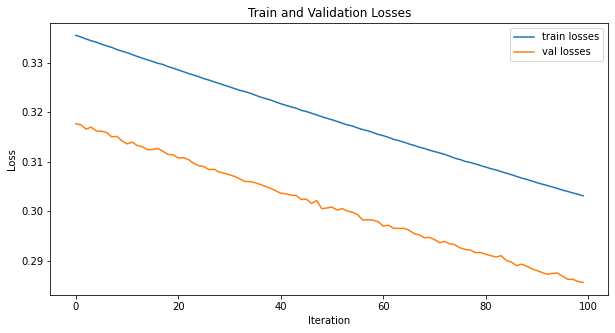

In [ ]:
draw_losses(train_losses, val_losses)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

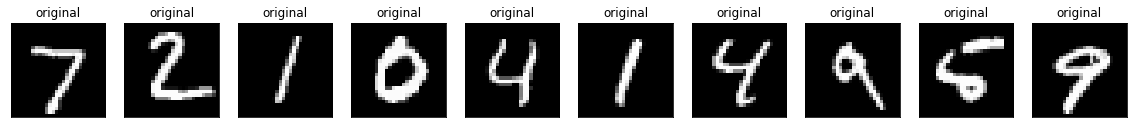

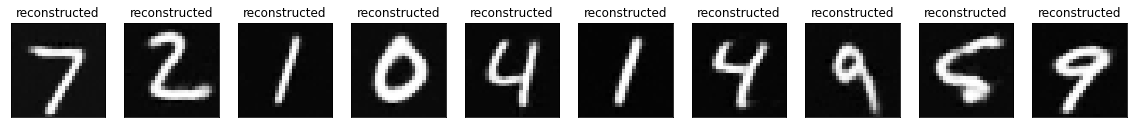

In [ ]:
reconstruct_and_draw(vae, mnist_val_data_loader)

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

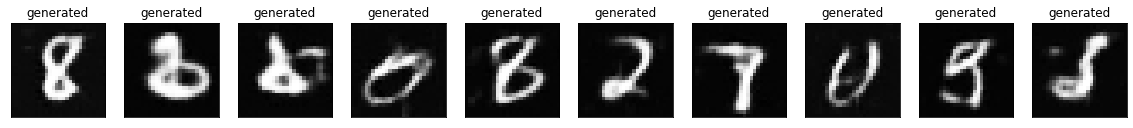

In [ ]:
sample_and_draw(vae, mnist_latent_size)

Видно, что половина вполне похожа на настоящие цифры

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

No handles with labels found to put in legend.


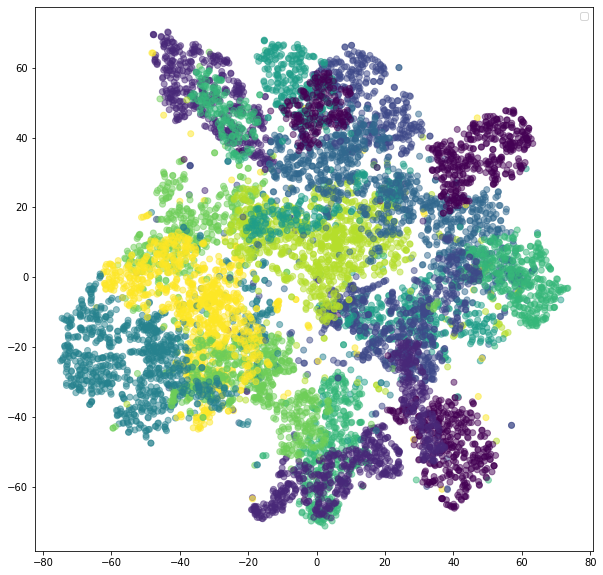

In [ ]:
draw_latent_vectors(vae, mnist_val_data_loader)

Что вы думаете о виде латентного представления?

Мы видим, что есть разрывы внутри одного класса

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [ ]:
class CVAE(nn.Module):
    def __init__(self, input_shape, latent_size, class_number):
        super().__init__()

        self.class_number = class_number

        input_channels = input_shape[0]
        input_size = input_shape[1]
        target_size = input_size // 4
       
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Flatten())
        
        self.mu = nn.Linear(64 * target_size * target_size + class_number, latent_size)
        self.logsigma = nn.Linear(64 * target_size * target_size + class_number, latent_size)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_size + class_number, 64 * target_size * target_size),
            nn.BatchNorm1d(64 * target_size * target_size),
            nn.ReLU(True),
            nn.Unflatten(1, (64, target_size, target_size)),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=input_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(input_channels),
            nn.Sigmoid())

    def encode(self, x, label):
        encoded = self.encoder(x)
        encoded = torch.cat([encoded, label], dim=1)
        
        mu = self.mu(encoded)
        logsigma = self.logsigma(encoded)
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            sigma = logsigma.exp()

            eps = torch.FloatTensor(sigma.size()).normal_().to(device)
            return eps.mul(sigma).add(mu)
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, label):
        z = torch.cat([z, label], dim=1)
        return self.decoder(z)

    def forward(self, x, label):
        one_hot_label = F.one_hot(torch.as_tensor(label), self.class_number)

        one_hot_label = one_hot_label.to(device)
        
        mu, logsigma = self.encode(x, one_hot_label)
        latent = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(latent, one_hot_label)

        return reconstruction, mu, logsigma

In [ ]:
cvae = CVAE(mnist_image_shape, mnist_latent_size, mnist_class_number).to(device)

optimizer = optim.Adam(cvae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
epoch_number = 300

train_losses, val_losses = train(cvae, loss_vae, optimizer, scheduler, epoch_number, mnist_train_data_loader, mnist_val_data_loader)

In [ ]:
torch.save(cvae.state_dict(), '/content/gdrive/MyDrive/autoencoders/models/mnist_cvae.pth')

Графики train и val loss

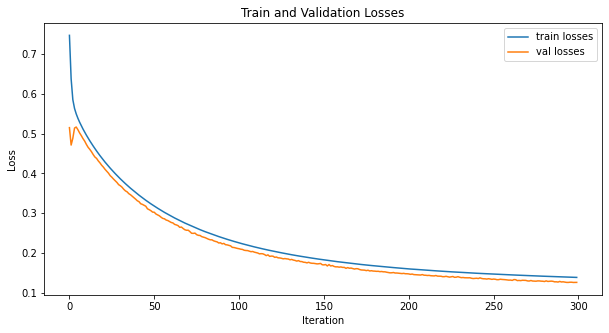

In [ ]:
draw_losses(train_losses, val_losses)

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

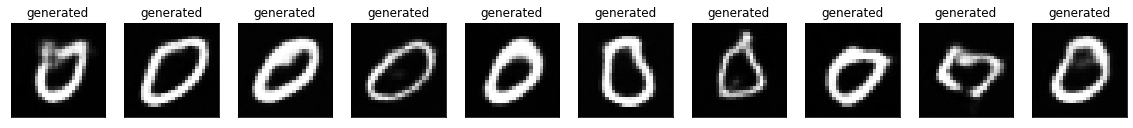

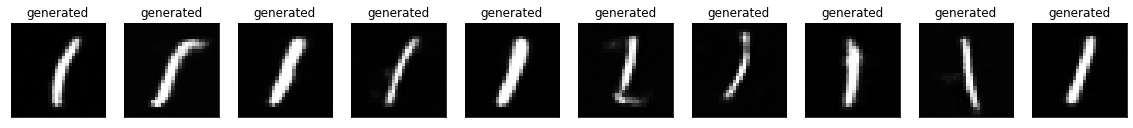

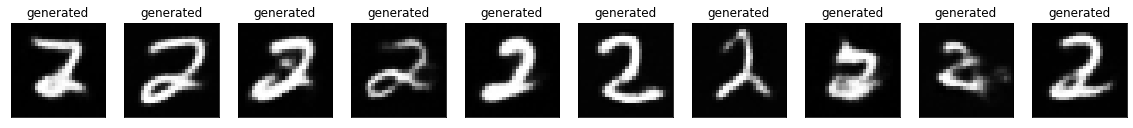

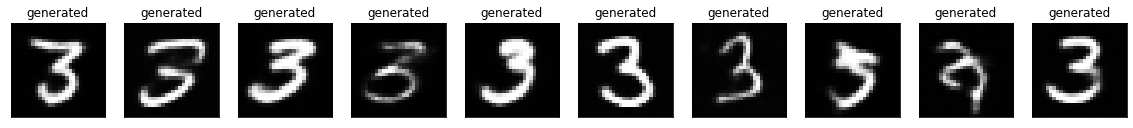

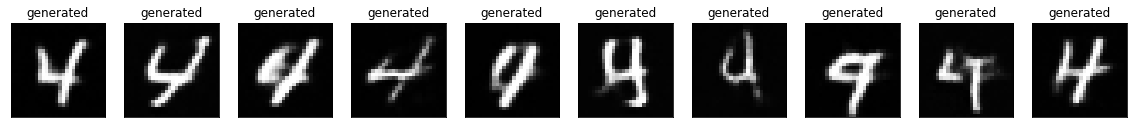

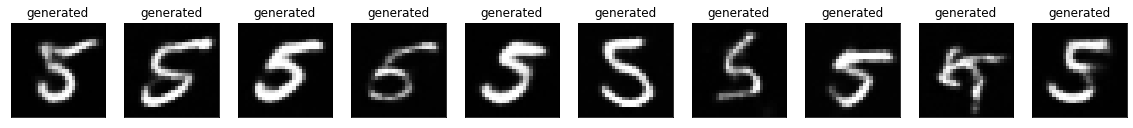

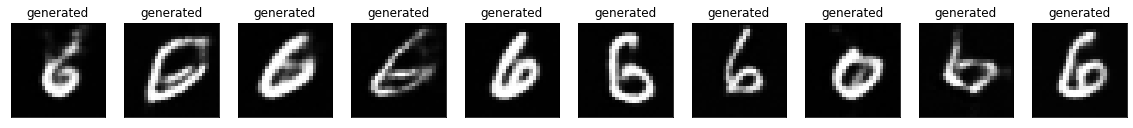

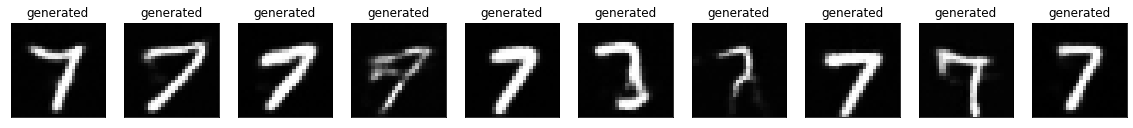

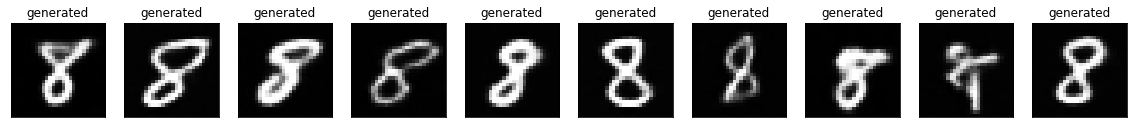

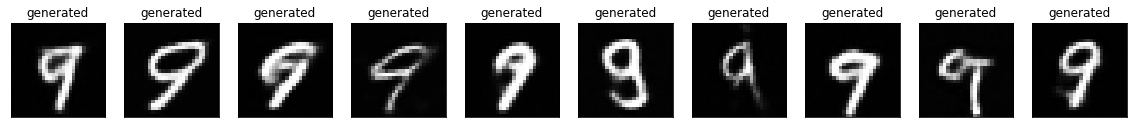

In [ ]:
sample_with_label_and_draw(cvae, mnist_latent_size, mnist_class_number)

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

No handles with labels found to put in legend.


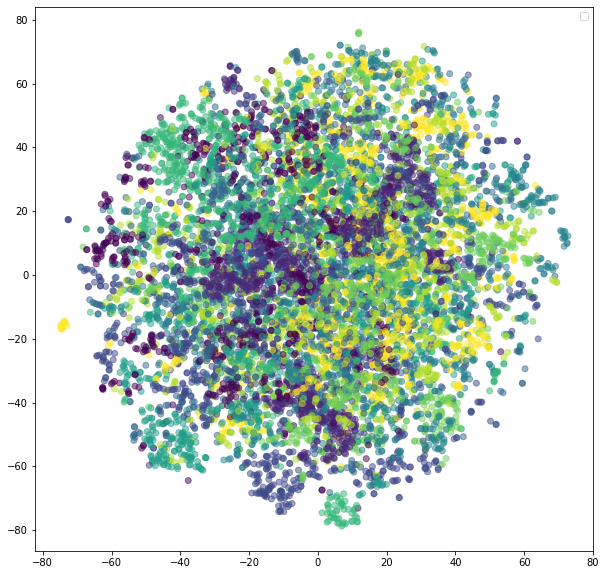

In [ ]:
draw_latent_vectors(cvae, mnist_val_data_loader)

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Отличается - разрывы внутри класса стали менее заметны

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

morfing image from 8 to 2


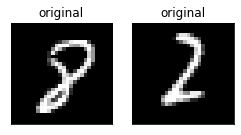

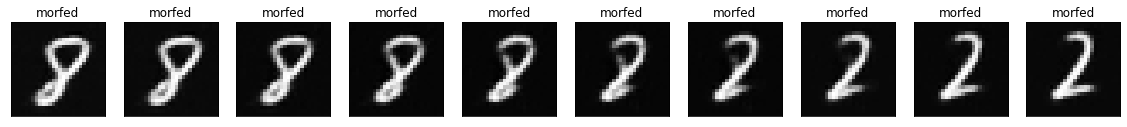

In [ ]:
iterator = iter(mnist_val_data_loader)

image_batch, label_batch = next(iterator)

rand = np.random.randint(0, mnist_batch_size, size=2)

image1 = image_batch[rand[0]].unsqueeze(dim=0)
image2 = image_batch[rand[1]].unsqueeze(dim=0)

label1 = label_batch[rand[0]]
label2 = label_batch[rand[1]]

image1 = image1.to(device)
image2 = image2.to(device)

mu1, logsigma1 = vae.encode(image1)
mu2, logsigma2 = vae.encode(image2)

X = vae.gaussian_sampler(mu1, logsigma1)
Y = vae.gaussian_sampler(mu2, logsigma2)

generated_images = []
for alpha in np.arange(0.0, 1.0, 0.1):
    latent = (1 - alpha) * X + alpha * Y

    image = vae.decode(latent).detach().cpu()
    image = image.squeeze(dim=0)

    generated_images.append(image)

image1 = image1.cpu()
image2 = image2.cpu()

image1 = image1.squeeze(dim=0)
image2 = image2.squeeze(dim=0)

original_images = [image1, image2]

print(f"morfing image from {label1} to {label2}")
draw_images(original_images, 2, "original")
draw_images(generated_images, 15, "morfed")

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

*Я не стал делать копию датасета с шумом, а добавляю шум внутри метода model.encode*

Опишем модель автоенкодера, убирающего шум. За основу возьмем Vanilla AE.

In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_shape, latent_size, noise_factor):
        super().__init__()

        self.noise_factor = noise_factor

        input_channels = input_shape[0]
        input_size = input_shape[1]
        target_size = input_size // 4
       
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(128 * target_size * target_size, latent_size),
            nn.BatchNorm1d(latent_size),
            nn.ReLU(True))
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 128 * target_size * target_size),
            nn.BatchNorm1d(128 * target_size * target_size),
            nn.ReLU(True),
            nn.Unflatten(1, (128, target_size, target_size)),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=32, out_channels=input_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(input_channels),
            nn.Sigmoid())

    def encode(self, x):
        x_noised = x
        if self.training:
            x_noised = torch.tensor(skimage.util.random_noise(x.cpu(), mode='gaussian', mean=0, var=self.noise_factor, clip=True))
            x_noised = x_noised.float().to(device)

        return self.encoder(x_noised)
    
    def decode(self, z):
        return self.decoder(z)
        
    def forward(self, x, label):
        latent = self.encode(x)
        reconstruction = self.decode(latent)

        return reconstruction, latent, latent

Создаем модель, оптимизатор и шедулер

In [ ]:
noise_factor = 0.05
denoising_ae = DenoisingAutoencoder(face_image_shape, face_latent_size, noise_factor).to(device)

optimizer = optim.Adam(denoising_ae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

Запускаем обучение. Я создал еще 1 кастомный loss - denoising_loss_vae, мои эксперименты показывают, что тут лучше уменьшить весь слагаемого KL в 10 раз по сравнению с VAE

In [ ]:
epoch_number = 200

train_losses, val_losses = train(denoising_ae, loss_ae, optimizer, scheduler, epoch_number, face_train_data_loader, face_val_data_loader)

In [ ]:
torch.save(ae.state_dict(), '/content/gdrive/MyDrive/autoencoders/models/face_denoising_ae.pth')

Графики train и val loss

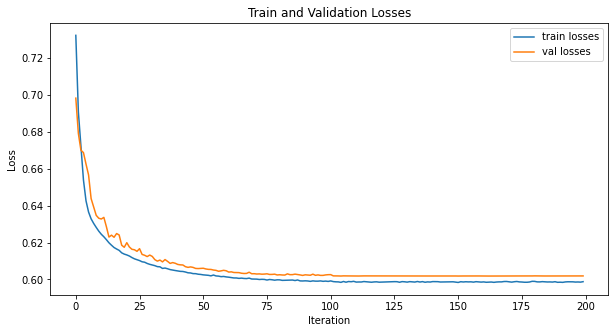

In [ ]:
draw_losses(train_losses, val_losses)

Покажем, как наша модель научилась убирать шум

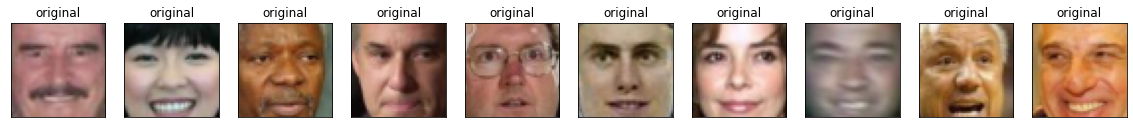

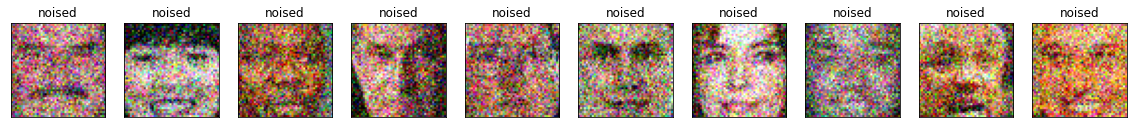

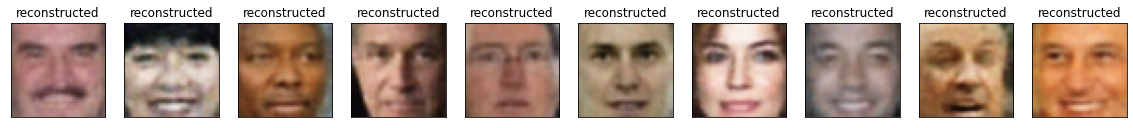

In [ ]:
image_batch, label_batch = next(iter(face_val_data_loader))

image_batch_noised = torch.tensor(skimage.util.random_noise(image_batch, mode='gaussian', mean=0, var=0.05, clip=True))
image_batch_noised = image_batch_noised.float().to(device)

image_batch_reconstructed, _, _ = denoising_ae(image_batch_noised, label_batch)

image_batch_noised = image_batch_noised.cpu()
image_batch_reconstructed = image_batch_reconstructed.detach().cpu()

draw_images(image_batch, 10, "original")
draw_images(image_batch_noised, 10, "noised")
draw_images(image_batch_reconstructed, 10, "reconstructed")

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

Возьмем такую же модель как в задании DenoisingAutoencoder и заменил шум на заполнение случайного прямоугольника белым цветом

In [ ]:
class OcclutingAutoencoder(nn.Module):
    def __init__(self, input_shape, latent_size, occlute_size):
        super().__init__()

        self.occlute_size = occlute_size

        input_channels = input_shape[0]
        self.input_size = input_shape[1]
        target_size = self.input_size // 4
       
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(128 * target_size * target_size, latent_size),
            nn.BatchNorm1d(latent_size),
            nn.ReLU(True))
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 128 * target_size * target_size),
            nn.BatchNorm1d(128 * target_size * target_size),
            nn.ReLU(True),
            nn.Unflatten(1, (128, target_size, target_size)),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=32, out_channels=input_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(input_channels),
            nn.Sigmoid())

    def encode(self, x):
        x_occluted = x
        if self.training:
            start = (random.randint(0, self.input_size), random.randint(0, self.input_size))
            extent = (random.randint(occlute_size[0], occlute_size[1]), random.randint(occlute_size[0], occlute_size[1]))
            rr, cc = rectangle(start, extent=extent, shape=(self.input_size, self.input_size))
            x_occluted[:, :, rr, cc] = 1

        return self.encoder(x_occluted)
    
    def decode(self, z):
        return self.decoder(z)
        
    def forward(self, x, label):
        latent = self.encode(x)
        reconstruction = self.decode(latent)

        return reconstruction, latent, latent

Создадим модель, оптимизатор и шедулер

In [ ]:
occlute_size = (5, 10)
occluting_ae = OcclutingAutoencoder(face_image_shape, face_latent_size, occlute_size).to(device)

optimizer = optim.Adam(occluting_ae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
epoch_number = 200

train_losses, val_losses = train(occluting_ae, loss_ae, optimizer, scheduler, epoch_number, face_train_data_loader, face_val_data_loader)

In [ ]:
torch.save(ae.state_dict(), '/content/gdrive/MyDrive/autoencoders/models/face_occlusion_ae.pth')

Графики train и val loss

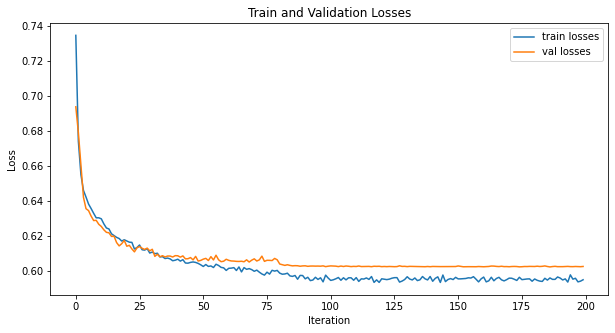

In [ ]:
draw_losses(train_losses, val_losses)

Покажем, как наша модель научилась восстанавливать occluted изображения

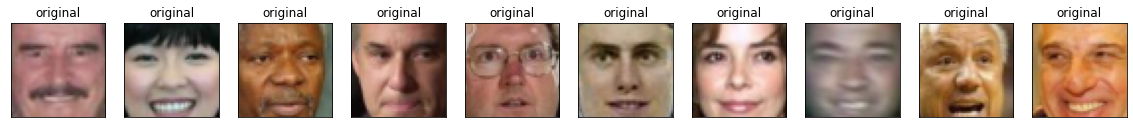

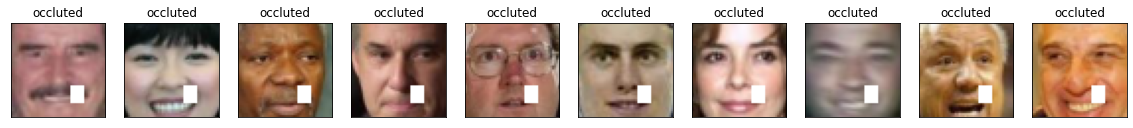

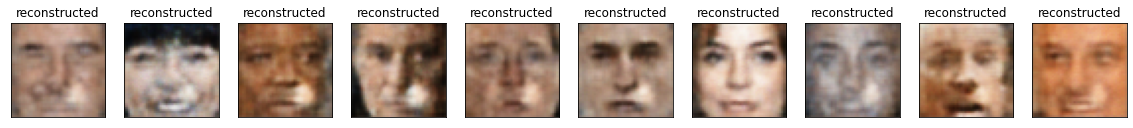

In [ ]:
image_batch, label_batch = next(iter(face_val_data_loader))

start = (random.randint(0, face_image_shape[1]), random.randint(0, face_image_shape[1]))
extent = (random.randint(5, 10), random.randint(5, 10))
rr, cc = rectangle(start, extent=extent, shape=(face_image_shape[1], face_image_shape[1]))
image_batch_occluted = image_batch.clone()
image_batch_occluted[:, :, rr, cc] = 1
image_batch_occluted = image_batch_occluted.to(device)

image_batch_reconstructed, _, _ = occluting_ae(image_batch_occluted, label_batch)

image_batch_occluted = image_batch_occluted.cpu()
image_batch_reconstructed = image_batch_reconstructed.detach().cpu()

draw_images(image_batch, 10, "original")
draw_images(image_batch_occluted, 10, "occluted")
draw_images(image_batch_reconstructed, 10, "reconstructed")

# Bonus 3: Image Retrieval (1 балл)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
latent_codes = []

for image_batch, label_batch in face_train_data_loader:
    image_batch = image_batch.to(device)
    latent = ae.encode(image_batch)
    latent = latent.detach().cpu()

    latent_codes.append(latent)

latent_codes = np.vstack(latent_codes)

In [ ]:
nearest_neighbors = KNeighborsTransformer().fit(latent_codes)

from joblib import dump, load
dump(nearest_neighbors, '/content/gdrive/MyDrive/autoencoders/models/knn.pth') 

['/content/gdrive/MyDrive/autoencoders/models/knn.pth']

In [ ]:
def get_similar(image, n_neighbors=5):
    # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
    # прогоняет векторы через декодер и получает картинки ближайших людей

    image = image.unsqueeze(dim=0).to(device)
    latent = ae.encode(image)
    latent = latent.detach().cpu()
    
    (distances,),(idx,) = nearest_neighbors.kneighbors(latent, n_neighbors=n_neighbors)

    return distances, idx

In [ ]:
def show_similar(image):
    # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbor_indexes = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.xticks([])
    plt.yticks([])
    plt.title("Original image")
    
    for i in range(11):
        neighbor_index = neighbor_indexes[i]
        neighbor_image, _ = face_train_data[neighbor_index]
        neighbor_image = neighbor_image.numpy().transpose([1,2,0])

        plt.subplot(3,4,i+2)
        plt.imshow(neighbor_image)
        plt.xticks([])
        plt.yticks([])
        plt.title("Dist=%.3f" % distances[i])

    plt.xticks([])
    plt.yticks([])
    plt.show()

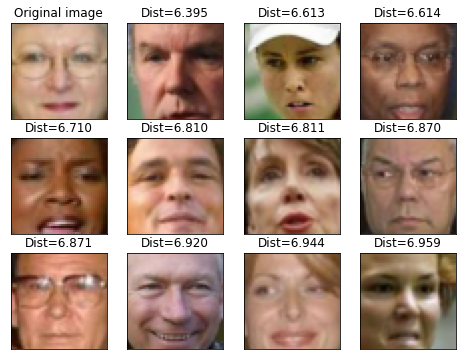

In [ ]:
image_batch, _ = next(iter(face_val_data_loader))
image = image_batch[random.randint(0, image_batch.shape[0])]

show_similar(image)

# Bonus 4: Телеграм-бот (3 балла)

Вы можете написать телеграм-бота с функционалом AE. Например, он может добавлять к вашей фотографии улыбку или искать похожие на ваше лицо лица среди лиц датасета. 

Код бота должно быть можно проверить!

Код бота размещен на https://github.com/msidorkevich/dls_part1_final_project

Сам бот доступен в телеграме - @similar_face_bot

Бот ресайзит исходную картинку в 48х45 и возвращает 5 лиц, похожих на исходное.

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!

**Мне понравился финальный проект, но я так и не понял, где я могу применить существующие модели в реальной жизни. АЕ плохо восстанавливают исходного изображение, искать похожие тоже получилось не очень**